# Wind Turbine Power Prediction
In this project I choose to use the Scada system’s wind power dataset to predict the wind turbine power prediction using the dataset attributes like speed and direction of the wind, month, and data. The dataset I considered for this project has approximately 50k records with 5 features.

To accomplish this project, I have created a data processing pipeline which does the data loading, transformation, data derivations, and aggregations. I have done analysis on this processed data using for the extraction of meaningful insights.

To handle this kind of data activities it is always suggested to use distributed data processing guidelines. So, I have followed the same to make sure that this project uses the data distribution capabilities effectively.

Initially, I have done my research to get the data for this project. After going through the multiple online resources, I choose Scada's dataset which is available in the Kaggle. I believe this dataset suffice the requirements to analyse the goal of this project. The dataset I choose has 50k records with 5 features. Here are the 5 features.

•	Date/Time

•	Wind Speed (m/s):  

•	LV ActivePower (kW):

•	TheoreticalPowerCurve (KWh):

•	Wind Direction (°):


After choosing the proper dataset, I have started off with the step of ingesting the dataset into a cloud storage so that it can be used effectively to make sure of no data loss.


## Importing Libraries and Spark Configuration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from warnings import filterwarnings
filterwarnings('ignore')

I am importing all the necessary libraries to use further for this project

In [2]:
# Downloading pyspark library
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=17dbf616a2d146cea884f9cc9fbb8a671cec2fa0e6383461751f9b0165dff874
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


Installing Pyspark library

In [3]:
# Importing pyspark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

# Configuration of Spark Session
spark = SparkSession.builder.master("local").appName("wind_turbine_project").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local appName=wind_turbine_project>

## Reading the Dataset

In [4]:
# Reading the dataset as Spark DataFrame
spark_df = spark.read.csv('/content/Data.csv', header=True, inferSchema=True)

# Caching the dataset
spark_df.cache()

# Converting all the column names to lower case
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])

print('Here are the first 5 rows')
print(spark_df.show(5))
print()
print('Variable data types:')
print(spark_df.printSchema())
print()
print('Total Observations:')
print(spark_df.count())

Here are the first 5 rows
+----------------+-------------------+----------------+-----------------------------+------------------+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|
+----------------+-------------------+----------------+-----------------------------+------------------+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|
+----------------+-------------------+----------------+-----------------------------+------------------+
only showing top 5 rows

None

I have logged sample of dataset, individual column level info about dataset, and total number of records in the dataset. Along with this code mentioned notebook has code of data understanding, cleaning, transformation, and analysis which we will discuss further in this document.

In [5]:
# Extracting a substring from columns to create month and hour variables

from pyspark.sql.functions import substring
spark_df = spark_df.withColumn("month", substring("date/time", 4,2))
spark_df = spark_df.withColumn("hour", substring("date/time", 12,2))

# Converting string month and hour variables to integer
from pyspark.sql.types import IntegerType
spark_df = spark_df.withColumn('month', spark_df.month.cast(IntegerType()))
spark_df = spark_df.withColumn('hour', spark_df.hour.cast(IntegerType()))

print(spark_df.show(5))

+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|       date/time|lv activepower (kw)|wind speed (m/s)|theoretical_power_curve (kwh)|wind direction (°)|month|hour|
+----------------+-------------------+----------------+-----------------------------+------------------+-----+----+
|01 01 2018 00:00|   380.047790527343|5.31133604049682|             416.328907824861|  259.994903564453|    1|   0|
|01 01 2018 00:10|    453.76919555664|5.67216682434082|             519.917511061494|   268.64111328125|    1|   0|
|01 01 2018 00:20|   306.376586914062|5.21603679656982|             390.900015810951|  272.564788818359|    1|   0|
|01 01 2018 00:30|   419.645904541015|5.65967416763305|             516.127568975674|  271.258087158203|    1|   0|
|01 01 2018 00:40|   380.650695800781|5.57794094085693|             491.702971953588|  265.674285888671|    1|   0|
+----------------+-------------------+----------------+-----------------

This code is for getting substrings from the "date/time" column to create new columns of month and hour for each entry.

I have used substring function from pyspark.sql.functions which is used to extract the substrings like two characters starting from the 4th position for month and two characters starting from the 12th position for hour. I have created new column with these substrings using withColumn.

Then, I am converting the extracted month and hour strings into integer types using cast and IntegerType from pyspark.sql.types.

I am displaying the first five rows of the DataFrame after these transformations to verify the changes made.

## Exploratory Data Analysis

This is an important step of this project, which is EDA where we try to understand the data what we have. By doing this EDA we can get to know the details of individual feature/attribute level distribution. And also we can understand relation between different variables using this EDA.

In [6]:
pd.options.display.float_format = '{:.2f}'.format
spark_df.select('wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)').toPandas().describe()

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
count,50530.00,50530.00,50530.00
mean,7.56,1492.18,1307.68
std,4.23,1368.02,1312.46
min,0.00,0.00,-2.47
25%,4.20,161.33,50.68
50%,7.10,1063.78,825.84
75%,10.30,2964.97,2482.51
max,25.21,3600.00,3618.73


As an initial step of EDA, I have shown the individual level distribution of each feature/attribute using different measure like count, mean, std, min, and max. I have achieved by converted spark dataframe to pandas and then calling describe on pandas df.

### Distributions of the variables:

This is to see the histograms for each variable distribution of a specific column from the sampled data such as wind speed, wind direction, month, hour, theoretical power curve, and active power.

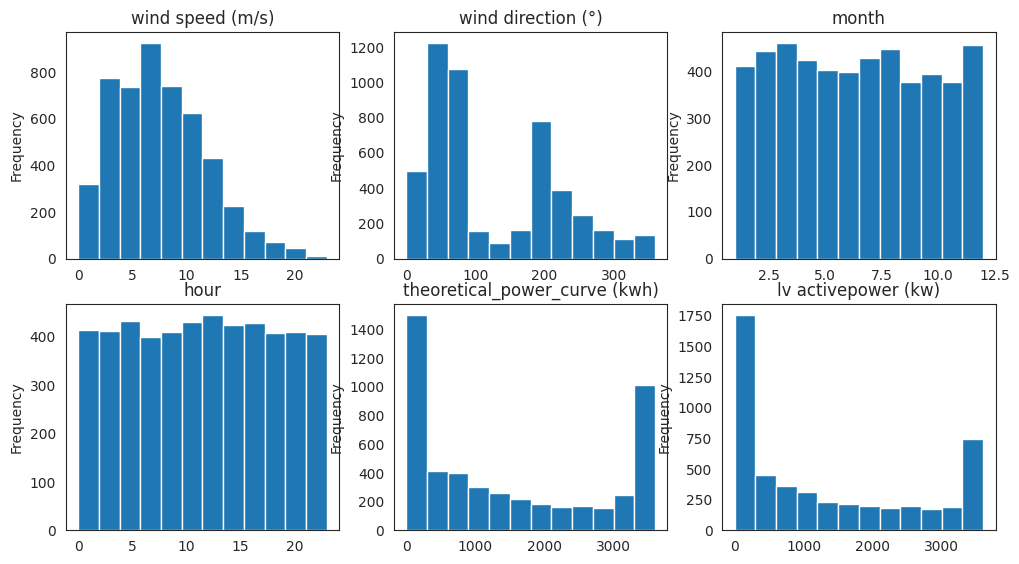

In [11]:
# Taking a random sample from the big data
sample_df = spark_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

# Visualizing the distributions with the sample data
columns = ['wind speed (m/s)', 'wind direction (°)', 'month', 'hour', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(12,10))
for each in columns:
    plt.subplot(3,3,i)
    sample_df[each].plot.hist(bins=12)
    plt.title(each)
    i += 1

### Finding the difference between the months for average power production

The below graph depicts monthly average power generation capability of turbines. For this, I have written code to group by month first then finding the mean of each month’s group. I have sorted those values in ascending order. Provided this data to seaborn barplot method to show in a graph.

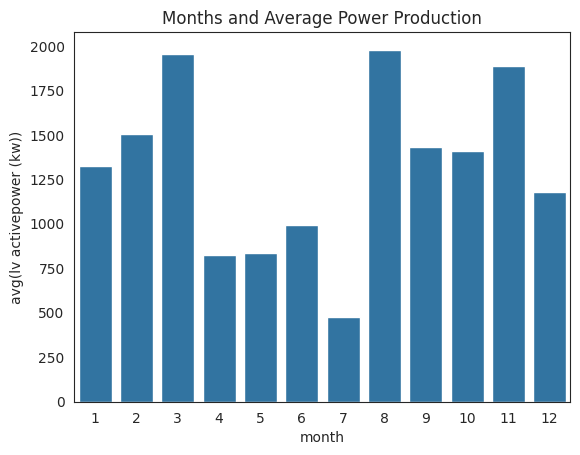

In [12]:
# Average power production by month
monthly = spark_df.groupby('month').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='month', y='avg(lv activepower (kw))', data=monthly)
plt.title('Months and Average Power Production');

### Difference between the hours for average power production

I have created a bar plot where each bar represents an hour, and its height corresponds to the average power production during that hour. As we can see that its maintain the same power generation on hourly basis.

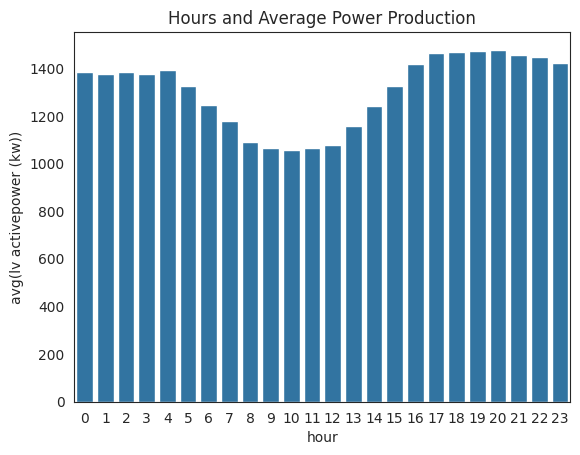

In [14]:
# Average power production by hour
hourly = spark_df.groupby('hour').mean('lv activepower (kw)').sort('avg(lv activepower (kw))').toPandas()
sns.barplot(x='hour', y='avg(lv activepower (kw))', data=hourly)
plt.title('Hours and Average Power Production');

### Correlation between the wind speed, wind direction and power production

The below table shows the how well one feature/attribute affects the other variable. By looking at the correlation value we can understand to what extent two variables are correlated. -1 refers to negatively correlated, 1 means positive correlation and 0 means no correlation. As an understanding from the table below we can see **wind speed and lv active power are highly correlated.**

Same can be seen using the pair plot diagram as shown below. It’s just a different way to interpret the correlation using the graph.

,wind speed (m/s),wind direction (°),month,hour,theoretical_power_curve (kwh),lv activepower (kw)
wind speed (m/s),1.00,-0.08,-0.01,0.03,0.95,0.91
wind direction (°),-0.08,1.00,-0.18,0.00,-0.11,-0.06
month,-0.01,-0.18,1.00,-0.01,-0.00,0.04
hour,0.03,0.00,-0.01,1.00,0.03,0.03
theoretical_power_curve (kwh),0.95,-0.11,-0.00,0.03,1.00,0.94
lv activepower (kw),0.91,-0.06,0.04,0.03,0.94,1.00


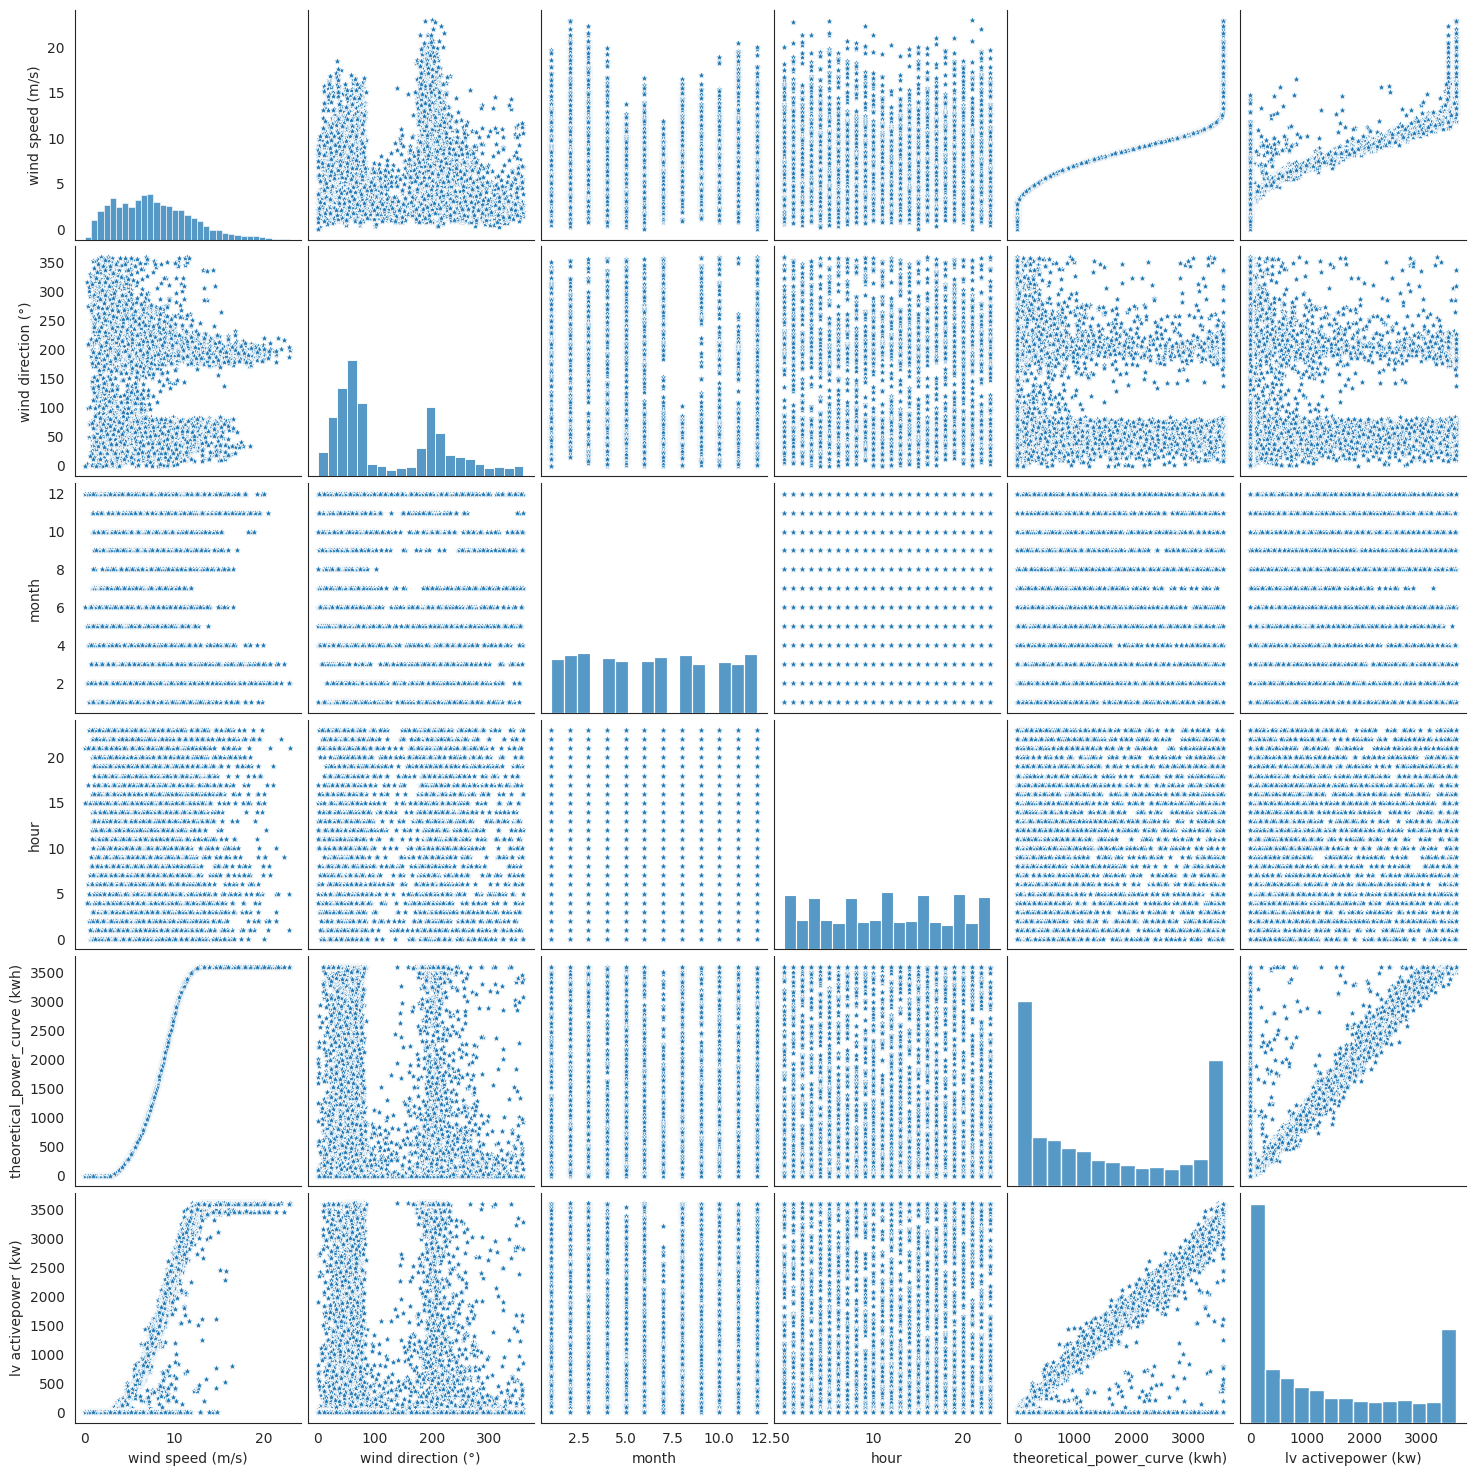

In [13]:
display(sample_df[columns].corr())
sns.pairplot(sample_df[columns], markers='*');

### Average power production level for different wind speeds

Here I am creating a boxplot which calculates the average power production for wind speed increments of 5 m/s from the Spark DataFrame.

From the graph below I can see that the power production reaches near a maximum level after the wind speed reaches 15 m/s.

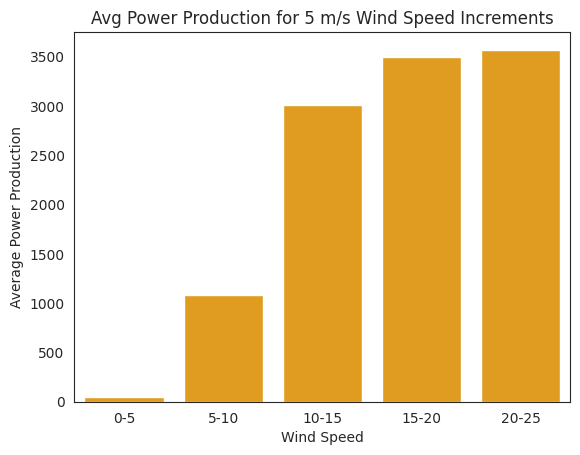

In [17]:
# Finding average power production for 5 m/s wind speed increments
wind_speed = []
avg_power = []
for i in [0,5,10,15,20]:
    avg_value = spark_df.filter((spark_df['wind speed (m/s)'] > i)
                                & (spark_df['wind speed (m/s)'] <= i+5))\
                                .agg({'lv activepower (kw)':'mean'}).collect()[0][0]
    avg_power.append(avg_value)
    wind_speed.append(str(i) + '-' + str(i+5))

sns.barplot(x=wind_speed, y=avg_power, color='orange')
plt.title('Avg Power Production for 5 m/s Wind Speed Increments')
plt.xlabel('Wind Speed')
plt.ylabel('Average Power Production');

### Power production for different wind directions and speeds

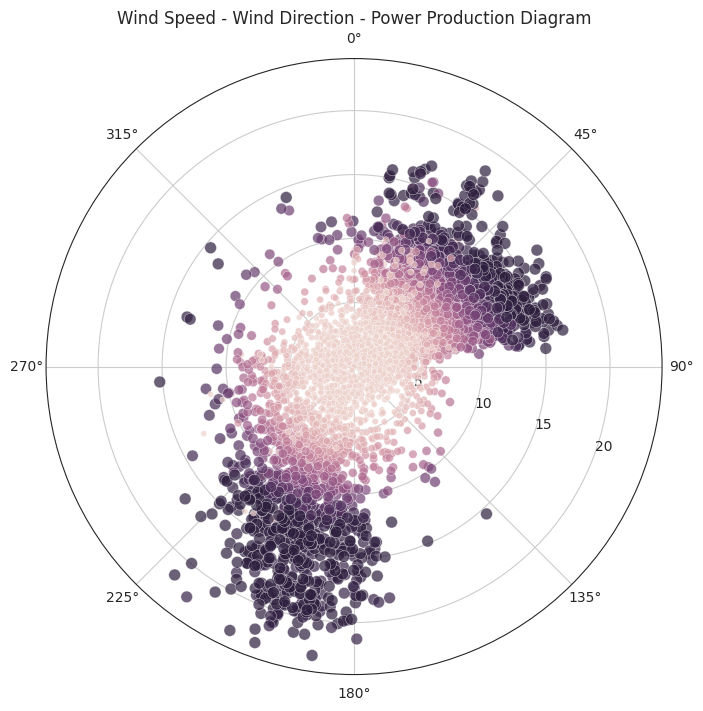

In [18]:
# Creating the polar diagram
from math import radians

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
# Inside circles are the wind speed and marker color and size represents the amount of power production
sns.scatterplot(x=[radians(x) for x in sample_df['wind direction (°)']],
                y=sample_df['wind speed (m/s)'],
                size=sample_df['lv activepower (kw)'],
                hue=sample_df['lv activepower (kw)'],
                alpha=0.7, legend=None)
# Setting the polar diagram's top represents the North
ax.set_theta_zero_location('N')
# Setting -1 to start the wind direction clockwise
ax.set_theta_direction(-1)
# Setting wind speed labels in a better position to see
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Power Production Diagram')
plt.ylabel(None);

### Scatter plot

As we got the evidence from the correlation section, I have plotted the relation between wind speed and power production(lv active power) using the scatter plot. If you look at the graph it’s evident that as the wind speed goes high the power generated is also going high. But it’s clear that there is clip at <3 and >12 level where wind speed not affecting power production much. To understand the distribution very well we plotted a line along the same lines.

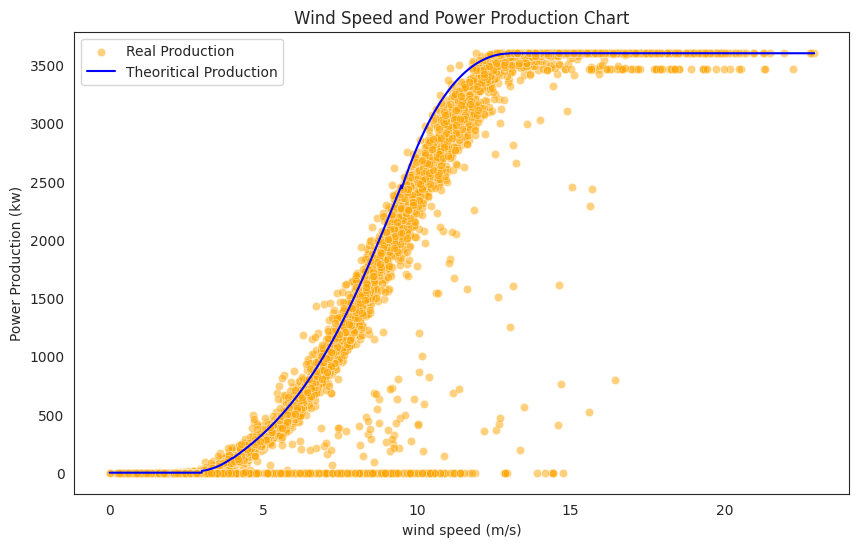

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='wind speed (m/s)', y='lv activepower (kw)', color='orange', label='Real Production', alpha=0.5, data=sample_df)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', color='blue', label='Theoritical Production', data=sample_df)
plt.title('Wind Speed and Power Production Chart')
plt.ylabel('Power Production (kw)');


### Wind speed threshold value for zero theorical power

Below table and graph is to understand the special scenario of zero power production at certain wind speed levels. As I mentioned earlier the wind level value below the level of 3 has less impact on power generation so we are seeing no power generated at that speed. If we see the graph also it’s evident that we have data points where power generation is nil and the range of that zone is less than 3.

,wind speed (m/s),theoretical_power_curve (kwh),lv activepower (kw)
6990,1.77,0.00,0.00
7027,2.48,0.00,0.00
983,2.95,0.00,0.00
1574,0.85,0.00,0.00
5489,2.58,0.00,0.00


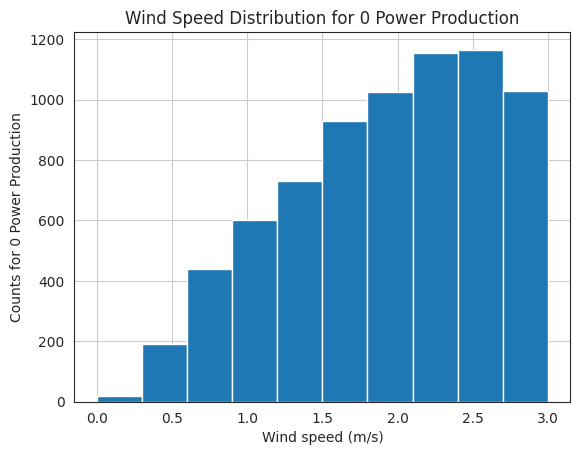

In [20]:
# Filter the big data where the real and theoritical power productions are equal to 0
zero_theo_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                                  & (spark_df['theoretical_power_curve (kwh)'] == 0)).toPandas()

display(zero_theo_power[['wind speed (m/s)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']].sample(5))

# Let's see the wind speed distribution for 0 power production
zero_theo_power['wind speed (m/s)'].hist()
plt.title('Wind Speed Distribution for 0 Power Production')
plt.xlabel('Wind speed (m/s)')
plt.ylabel('Counts for 0 Power Production');


### Observed that there are no power production in some observations while the wind speed is higher than 3 m/s

In [21]:
# Observations for the wind speed > 3m/s and power production = 0,
# While theoritically there should be power production
zero_power = spark_df.filter((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)).toPandas()
display(zero_power.head())
print('No of Observations (while Wind Speed > 3 m/s and Power Production = 0): ', len(zero_power))

,date/time,lv activepower (kw),wind speed (m/s),theoretical_power_curve (kwh),wind direction (°),month,hour,label
0,03 01 2018 15:40,0.00,3.74,83.99,245.07,1,15,0.00
1,03 01 2018 16:40,0.00,3.03,17.18,221.09,1,16,0.00
2,03 01 2018 16:50,0.00,3.20,25.43,232.68,1,16,0.00
3,03 01 2018 17:00,0.00,3.91,110.98,241.97,1,17,0.00
4,04 01 2018 13:50,0.00,3.44,45.74,79.09,1,13,0.00


No of Observations (while Wind Speed > 3 m/s and Power Production = 0):  3497


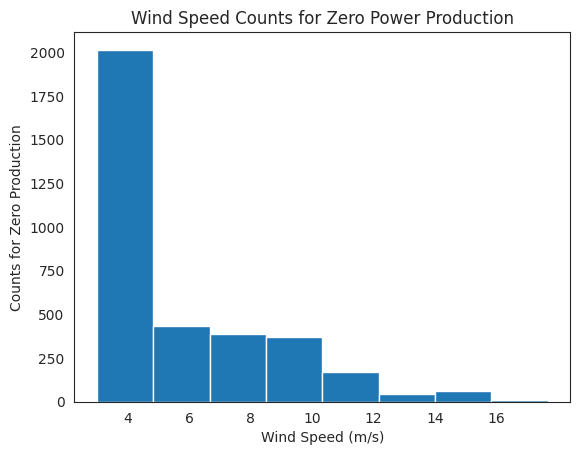

In [22]:
zero_power['wind speed (m/s)'].plot.hist(bins=8)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Counts for Zero Production')
plt.title('Wind Speed Counts for Zero Power Production')
plt.xticks(ticks=np.arange(4,18,2));

According to theory wind turbines should start producing power once wind speeds reaches 4 m/s. but there are instances where even with wind speeds higher than this threshold, power production remains at zero.

We need to examine the monthly breakdown of these occurrences when power production is at zero when wind speeds being above the expected threshold.

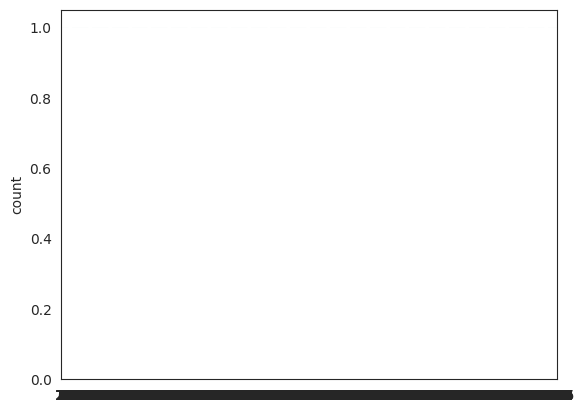

In [37]:
sns.countplot(zero_power['month']);

**It is usually in December and January when the wind turbine doesn't produce production.**

**Because I cannot decide if these zero power productions are caused by maintenance periods or something else, I am going to accept those 3497 observations as outliers and remove them from the dataset.**

In [24]:
# Excluding the observations meeting the filter criterias
spark_df = spark_df.filter(~((spark_df['lv activepower (kw)'] == 0)
                            & (spark_df['theoretical_power_curve (kwh)'] != 0)
                            & (spark_df['wind speed (m/s)'] > 3)))

### Finding and removing outliers

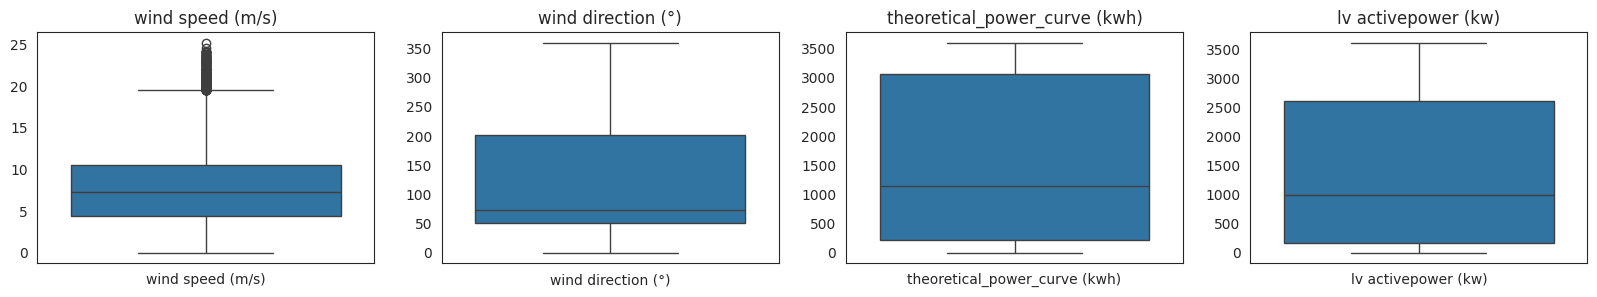

In [25]:
columns = ['wind speed (m/s)', 'wind direction (°)', 'theoretical_power_curve (kwh)', 'lv activepower (kw)']
i=1
plt.figure(figsize=(20,3))
for each in columns:
    df = spark_df.select(each).toPandas()
    plt.subplot(1,4,i)
    sns.boxplot(df)
    plt.title(each)
    i += 1

In [26]:
# Create a pandas df for visualization
wind_speed = spark_df.select('wind speed (m/s)').toPandas()

# Defining the quantiles and interquantile range
Q1 = wind_speed['wind speed (m/s)'].quantile(0.25)
Q3 = wind_speed['wind speed (m/s)'].quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.45584678649902   Quantile (0.75):  10.4771900177001
Lower threshold:  -4.576168060302599  Upper threshold:  19.50920486450172


In [27]:
# Fancy indexing for outliers
outlier_tf = (wind_speed['wind speed (m/s)'] < lower) | (wind_speed['wind speed (m/s)'] > upper)

print('Total Number of Outliers: ', len(wind_speed['wind speed (m/s)'][outlier_tf]))
print('--'*15)
print('Some Examples of Outliers:')
print(wind_speed['wind speed (m/s)'][outlier_tf].sample(10))

Total Number of Outliers:  407
------------------------------
Some Examples of Outliers:
10894   20.85
3579    20.93
2421    19.92
3571    21.11
3565    20.54
8911    20.23
8939    19.91
46330   19.93
3533    23.06
2419    20.31
Name: wind speed (m/s), dtype: float64


**It is a rare event for wind speed to be over 19 m/s in our dataset.**

**Out of 47033, there is only 407 observations while the wind speed is over 19 m/s.**

**Now I want to see average power production for these high wind speed.**

In [28]:
spark_df.select('wind speed (m/s)', 'lv activepower (kw)')\
.filter(spark_df['wind speed (m/s)'] >= 19)\
.agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      3566.4634427974706|
+------------------------+



**So instead of erasing the outliers, I am going to set the wind speed as 19 m/s for those observations.**

In [29]:
from pyspark.sql import functions as F
spark_df = spark_df.withColumn('wind speed (m/s)',
                               F.when(F.col('wind speed (m/s)') > 19.447, 19)
                               .otherwise(F.col('wind speed (m/s)')))
spark_df.count()

47033

### Analysis of EDA:

•	I see that from the above graph that in March, August and November, the average power production is higher.

•	Between 16:00 and 24:00 on a daily average, more power is produced.

•	When the wind blows from directions between 000-090 and 180-225 degrees, more power is produced.


In [30]:
# High level power production
spark_df.filter(((spark_df['month'] == 3) | (spark_df['month'] == 8) | (spark_df['month'] == 11))
                & ((spark_df['hour'] >= 16) | (spark_df['hour'] <= 24))
                & ((spark_df['wind direction (°)'] > 0) | (spark_df['wind direction (°)'] < 90))
                & ((spark_df['wind direction (°)'] > 180) | (spark_df['wind direction (°)'] < 225))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|      2013.4446757880403|
+------------------------+



In [31]:
# Low level power production
spark_df.filter((spark_df['month'] == 7)
                & ((spark_df['hour'] >= 9) | (spark_df['hour'] <= 11))
                & ((spark_df['wind direction (°)'] > 90) | (spark_df['wind direction (°)'] < 160))
               ).agg({'lv activepower (kw)':'mean'}).show()

+------------------------+
|avg(lv activepower (kw))|
+------------------------+
|       503.1644205414878|
+------------------------+



## Data Preparation for ML Algorithms

As a next step I have converted the all features into vector to feed to the model. I have done this using the VectorAssembler where it takes all the features and gives a single feature of vectorized form. As shown in the screenshot now we have two features one is features and the other one is our target variable which is label.

In [32]:
# Preparing the independent variables (Features)
from pyspark.ml.feature import VectorAssembler

# Converting lv activepower (kw) variable as label
spark_df = spark_df.withColumn('label', spark_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
va_df = vectorAssembler.transform(spark_df)

# Combining features and label column
final_df = va_df.select('features', 'label')
final_df.show(10)

+--------------------+----------------+
|            features|           label|
+--------------------+----------------+
|[1.0,0.0,5.311336...|380.047790527343|
|[1.0,0.0,5.672166...| 453.76919555664|
|[1.0,0.0,5.216036...|306.376586914062|
|[1.0,0.0,5.659674...|419.645904541015|
|[1.0,0.0,5.577940...|380.650695800781|
|[1.0,0.0,5.604052...|402.391998291015|
|[1.0,1.0,5.793007...|447.605712890625|
|[1.0,1.0,5.306049...|     387.2421875|
|[1.0,1.0,5.584629...|463.651214599609|
|[1.0,1.0,5.523228...|439.725708007812|
+--------------------+----------------+
only showing top 10 rows



## Train Test Split

**Here I am splitting our dataset into train and test datasets.**

In [33]:
splits = final_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

print('Train dataset: ', train_df.count())
print('Test dataset : ', test_df.count())

Train dataset:  37598
Test dataset :  9435


## Creating the Initial Model

Finally, we are at the step of modelling. I used GBTRegressor as a prediction model which works on regression problems. This model takes previously mentioned features vector and labelCol as our label column. The training has been done using the fit method and prediction using the transform method. Now we have prediction values as y_pred which can be used for evaluation.

In [34]:
from pyspark.ml.regression import GBTRegressor

# Creating the gbm regressor object
gbm = GBTRegressor(featuresCol='features', labelCol='label')

# Training the model with train data
gbm_model = gbm.fit(train_df)

# Predicting using the test data
y_pred = gbm_model.transform(test_df)

# Initial look at the target and predicted values
y_pred.select('label', 'prediction').show(20)

+----------------+------------------+
|           label|        prediction|
+----------------+------------------+
|             0.0|20.391409679803107|
|             0.0|20.141424152870883|
|22.8495998382568| 24.75630915611886|
|314.634796142578|318.09967803287657|
|576.870971679687| 634.6998281144537|
|  777.2919921875| 662.3096844931713|
|845.205017089843| 727.5801304649931|
|994.749572753906| 902.1201874383787|
|1182.03503417968| 1171.666471336759|
|1085.18200683593|1215.9692290394146|
|1878.79504394531|1919.3824726549246|
|2157.01806640625|1993.0289384199584|
|2455.43310546875|2370.4747327592504|
|2782.56811523437|  2563.60472485695|
|1331.80395507812| 3326.889863063862|
|3599.26904296875|3442.0604067555405|
|3538.52099609375|3442.0604067555405|
|794.039611816406| 752.3931482478646|
|3460.57397460937|3442.0604067555405|
|             0.0|18.820678490498587|
+----------------+------------------+
only showing top 20 rows



**Evaluation of the model's performance**

In [35]:
# Initial model success
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='label')

print('R2 SCORE : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'r2'}))
print('MAE      : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'mae'}))
print('RMSE     : ', evaluator.evaluate(y_pred, {evaluator.metricName: 'rmse'}))

R2 SCORE :  0.9797976484298669
MAE      :  84.10566512850573
RMSE     :  185.11755386627294


Now we must evaluate our model. Using the y_pred which we got earlier we need to evaluate our model. I used RegressionEvaluator of pyspark.ml library to get different metrics like R2 Score, MAE, RMSE. As shown in the screenshot we have achieved R2 score of 0.98, MAE of 84.10, and RMSE of 185.117. From the R2 value we can expect that our model can explain 97% of variability of data. And also from the other metrics we achieved it’s evident that our is decent enough according o prediction power.

## Comparing Theoritical, Real and Predicted Power Productions

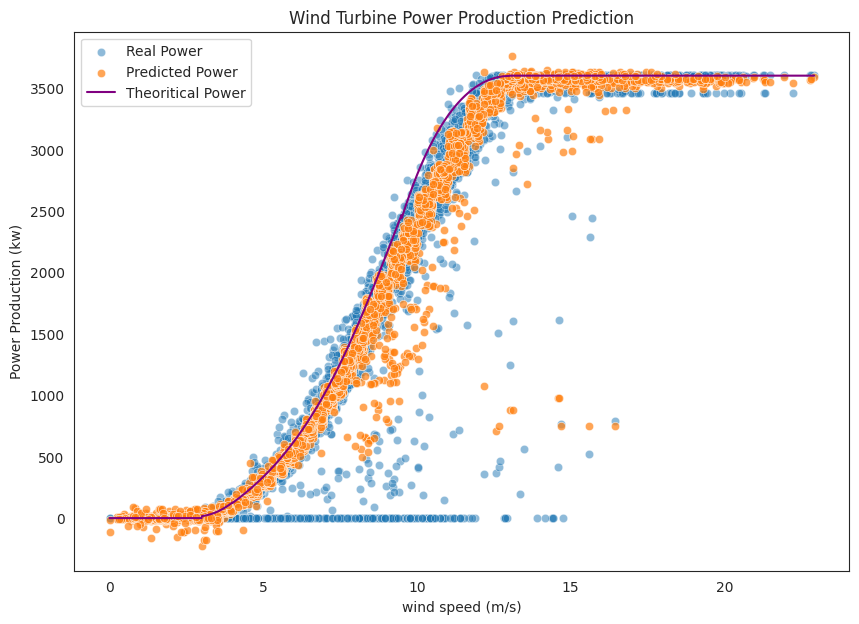

In [36]:
# Converting sample_df back to Spark dataframe
eva_df = spark.createDataFrame(sample_df)

# Converting lv activepower (kw) variable as label
eva_df = eva_df.withColumn('label', eva_df['lv activepower (kw)'])

# Defining the variables to be used
variables = ['month', 'hour', 'wind speed (m/s)', 'wind direction (°)']
vectorAssembler = VectorAssembler(inputCols = variables, outputCol = 'features')
vec_df = vectorAssembler.transform(eva_df)

# Combining features and label column
vec_df = vec_df.select('features', 'label')

# Using ML model to predict
preds = gbm_model.transform(vec_df)
preds_df = preds.select('label','prediction').toPandas()

# Compining dataframes to compare
frames = [sample_df[['wind speed (m/s)', 'theoretical_power_curve (kwh)']], preds_df]
sample_data = pd.concat(frames, axis=1)

# Visualizing real, theoritical and predicted power production
plt.figure(figsize=(10,7))
sns.scatterplot(x='wind speed (m/s)', y='label',alpha=0.5, label= 'Real Power', data=sample_data)
sns.scatterplot(x='wind speed (m/s)', y='prediction', alpha=0.7, label='Predicted Power', marker='o', data=sample_data)
sns.lineplot(x='wind speed (m/s)', y='theoretical_power_curve (kwh)', label='Theoritical Power',color='purple', data=sample_data)
plt.title('Wind Turbine Power Production Prediction')
plt.ylabel('Power Production (kw)')
plt.legend();